# T-Maze Inference for Planning with GBFE

In [62]:
using Pkg
Pkg.activate("../..")
# Pkg.instantiate()

  Activating project at `c:\Simulations\EpistemicMessagePassing`


In [63]:
using LinearAlgebra
using ForneyLab
using Plots
using ForwardDiff: hessian

# T-maze layout
# [2| |3]
#   | |
#   |1|
#   |4|

include("factor_nodes/discrete_observation.jl")
include("update_rules/discrete_observation.jl")
;

In [64]:
# Reward probability and utility, uncomment scenario of interest
α = 0.9; c = 2.0

include("environment.jl")
include("agent.jl")
include("helpers.jl")

(A, B, C, D) = constructABCD(α, c)

A_0 = 10.0*(A .+ 0.01)
C_0 = 100.0*(C .+ 0.01)
;

# Model

In [65]:
T = 2

fg = FactorGraph()

u = Vector{Variable}(undef, T)
x = Vector{Variable}(undef, T)

@RV x_t_min ~ Categorical(placeholder(:D_t_min, dims=(8,)))
@RV A_t ~ Dirichlet(A_0)
@RV c_t ~ Dirichlet(C_0)

x_k_min = x_t_min
for k=1:T
    @RV u[k]
    @RV x[k] ~ Transition(x_k_min, u[k],id=:x_*k)

    placeholder(u[k], :u, index=k, dims=(8,8))
    DiscreteObservation(x[k], A_t, c_t, n_factors=8)
    
    x_k_min = x[k]
end
;

In [66]:
q = PosteriorFactorization([x_t_min; x], A_t, c_t, ids=[:X, :A, :C])
algo = messagePassingAlgorithm(x_t_min, free_energy=true)
code = algorithmSourceCode(algo, free_energy=true)
eval(Meta.parse(code))
;

In [67]:
# println(code)

# Results

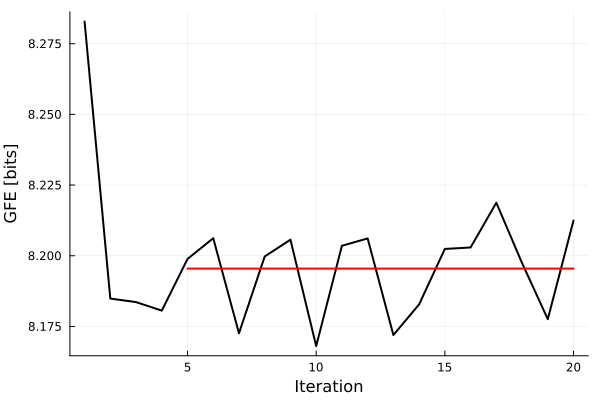

In [68]:
# Single policy
pi = [4, 2]

n_its = 20
G = zeros(n_its)

data = Dict(:u       => [B[pi[1]], B[pi[2]]],
            :A       => A,
            :C       => [C, C],
            :D_t_min => D)

marginals = Dict{Symbol, ProbabilityDistribution}(
    :x_t_min => ProbabilityDistribution(Univariate, Categorical, p=D),
    :x_1 => ProbabilityDistribution(Univariate, Categorical, p=asym(8)),
    :x_2 => ProbabilityDistribution(Univariate, Categorical, p=asym(8)),
    :A_t => ProbabilityDistribution(MatrixVariate, Dirichlet, a=A_0),
    :c_t => ProbabilityDistribution(Multivariate, Dirichlet, a=C_0))

messages = initX()

for k=1:n_its
    stepX!(data, marginals, messages)
    stepC!(data, marginals, messages)
    stepA!(data, marginals, messages)
    G[k] = freeEnergy(data, marginals)
end
  
G = G./log(2) # Convert to bits

range = 5:n_its
G_bar = mean(G[range]) # Average over final iterations

plot(1:n_its, G, color=:black, grid=true, linewidth=2, legend=false, xlabel="Iteration", ylabel="GFE [bits]")
plot!(range, G_bar*ones(length(range)), color=:red, linewidth=2)

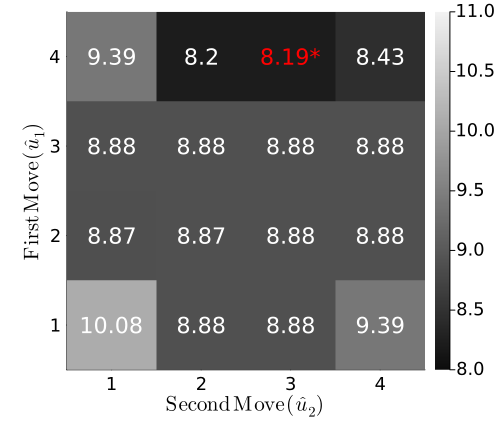

In [69]:
# GBFE for all policies
GBFE = evaluatePoliciesFullGBFE(A, B, C, D, n_its=n_its)
plotResults(GBFE, clim=(8.0,11.0), dpi=300, highlight=minimum)
#savefig("GBFE_c_$(c)_a_$(α).png")